Pipeline cargado exitosamente desde: ./resultados_FIN_v2/fold_1/classifier_logreg_pipeline_fold_1.joblib

Pasos del Pipeline:
Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=0.006270534777031359,
                                    class_weight='balanced', max_iter=2000,
                                    random_state=42, solver='liblinear'))])

Archivo de mapeo AAL a Yeo17 cargado. 131 ROIs.

--- Análisis de Importancia de Características (Clasificador LogReg) ---
Importancia total extraída para 514 características.

Importancia de los Metadatos:
    feature  coefficient  abs_coefficient
18      Sex    -0.031630         0.031630
268     Age    -0.010262         0.010262

Top 10 Características Latentes más importantes:
      feature  coefficient  abs_coefficient
0  latent_430    -0.046021         0.046021
1  latent_260     0.043950         0.043950
2  latent_447     0.041007         0.041

/tmp/ipykernel_3276314/2386005236.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Gráfico de importancia de características latentes guardado como 'top_20_latent_features.png'


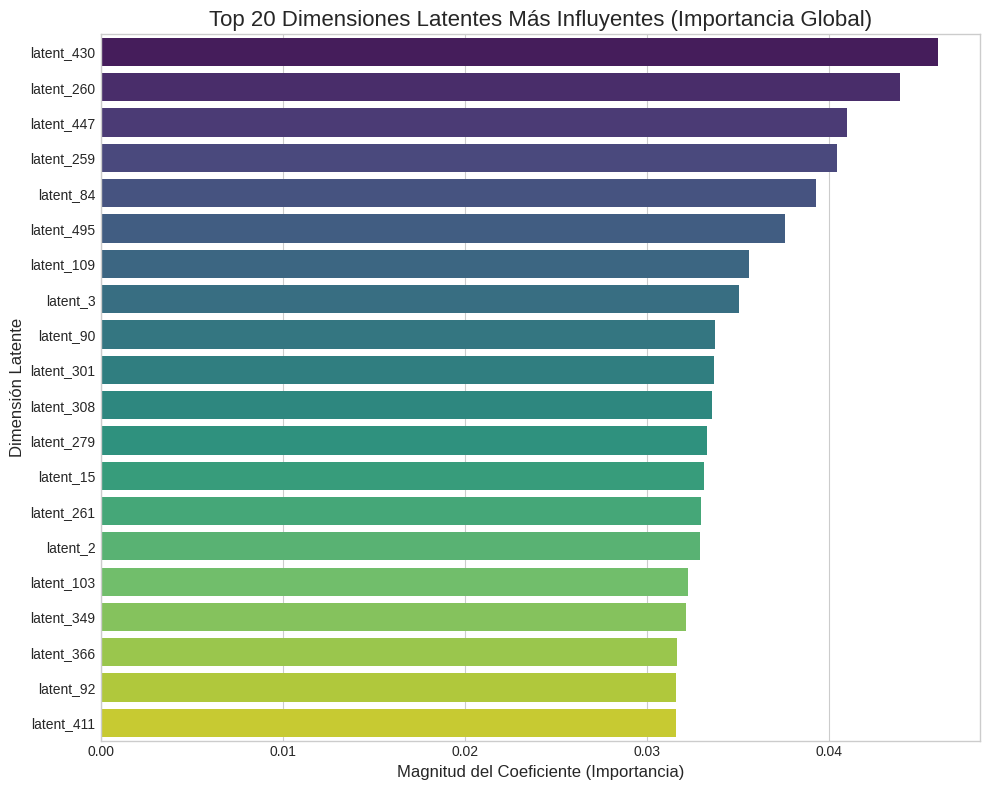


--- SIMULACIÓN: Ranking de Redes Funcionales a partir de Saliencia por ROI ---
Ranking de redes funcionales (basado en datos de saliencia simulados):
                  Yeo17_Network  Yeo17_Label   saliency  contribution_percent
0        Background/NonCortical            0  14.653426             23.387967
1      DefaultMode_DorsalMedial           16   7.305154             11.659574
2             Visual_Peripheral            1   7.024304             11.211317
3             Limbic_A_TempPole            9   6.114858              9.759772
4                  Limbic_B_OFC           10   5.044264              8.051024
5                 Somatomotor_A            3   3.206075              5.117137
6   Salience_VentralAttention_A            7   3.041762              4.854880
7                Visual_Central            2   2.881088              4.598433
8                     Control_A           12   2.455564              3.919264
9             DorsalAttention_A            5   2.078643              

/tmp/ipykernel_3276314/2386005236.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Gráfico de ranking de redes (simulado) guardado como 'simulated_network_ranking.png'


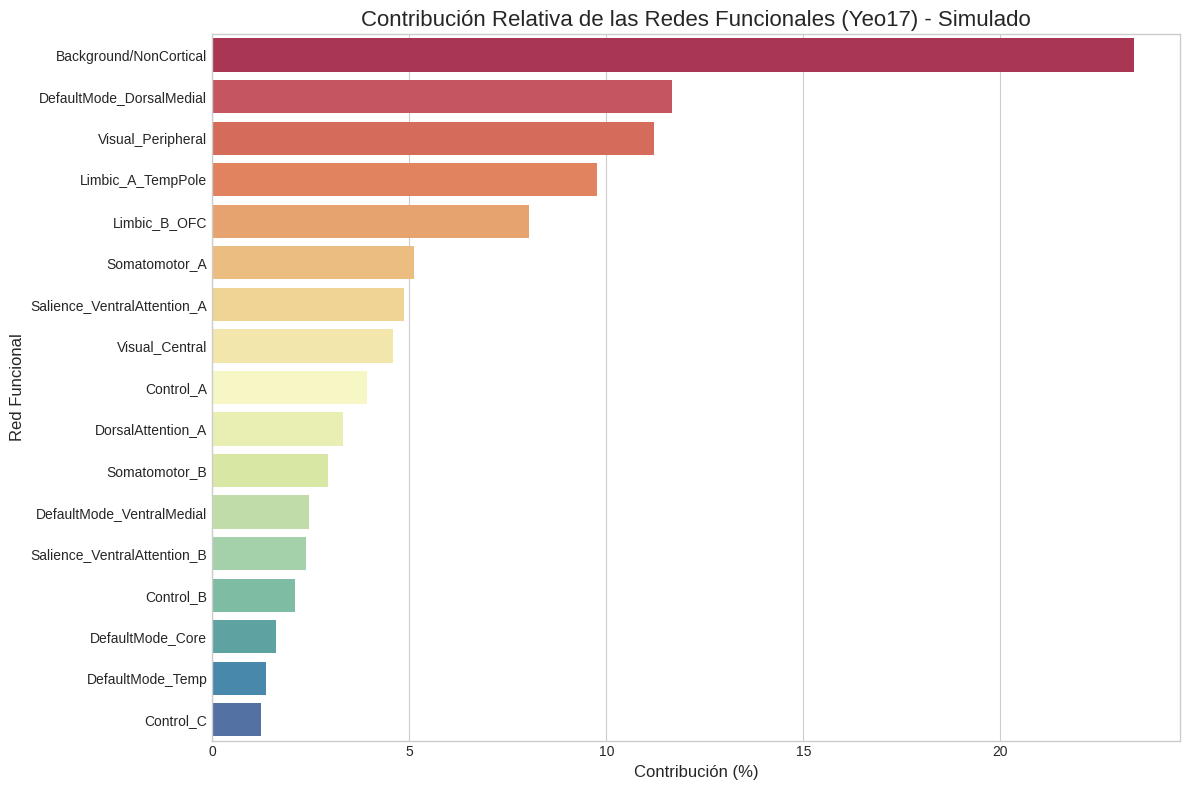

In [1]:
# -*- coding: utf-8 -*-
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# # Capa 1: Análisis de Importancia Global del Clasificador (Versión Corregida)
# 
# En este notebook, realizaremos el primer paso del itinerario de interpretabilidad: entender qué características son más importantes para nuestro modelo a nivel global.
# 
# **El Desafío**: Nuestro clasificador de Regresión Logística no opera sobre los 131 ROIs directamente, sino sobre un **vector de 514 características**:
# * 512 dimensiones del espacio latente del VAE.
# * 2 características de metadatos (`Age`, `Sex`).
# 
# Por tanto, no podemos mapear directamente los coeficientes del modelo a las redes cerebrales.
# 
# **Nuestra Estrategia**:
# 1.  **Análisis en el Espacio Latente**: Identificaremos qué dimensiones latentes y qué metadatos tienen más peso para el clasificador. Esto nos dirá qué "conceptos" abstractos aprendidos por el VAE son los más relevantes.
# 2.  **Puente al Espacio Cerebral**: Prepararemos la lógica para que, cuando generemos mapas de saliencia (Capa 2), podamos proyectar esa importancia de vuelta al cerebro y agregarla por red funcional (Yeo17).

# ## Paso 1: Cargar Modelos y Datos Necesarios

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuración ---
# Modifica estas rutas según la ubicación de tus archivos
MODEL_PATH = './resultados_FIN_v2/fold_1/classifier_logreg_pipeline_fold_1.joblib'
MAPPING_PATH = './aal3_131_to_yeo17_mapping.csv'
METADATA_FEATURES = ['Age', 'Sex'] # Los mismos que usaste en el entrenamiento

# --- Cargar el pipeline del clasificador ---
try:
    pipeline = joblib.load(MODEL_PATH)
    print(f"Pipeline cargado exitosamente desde: {MODEL_PATH}")
    print("\nPasos del Pipeline:")
    print(pipeline)
except FileNotFoundError:
    print(f"Error: No se encontró el archivo del modelo en {MODEL_PATH}")
    print("Asegúrate de que la ruta sea correcta y que el artefacto del fold se haya guardado.")
    # Salimos si no se puede cargar el modelo
    exit()
    
# --- Cargar el mapeo AAL3 a Yeo17 ---
try:
    yeo_mapping_df = pd.read_csv(MAPPING_PATH)
    print(f"\nArchivo de mapeo AAL a Yeo17 cargado. {yeo_mapping_df.shape[0]} ROIs.")
    # Asumimos que los ROIs están en orden del 1 al 131
    yeo_mapping_df['roi_index'] = yeo_mapping_df.index
except FileNotFoundError:
    print(f"Error: No se encontró el archivo de mapeo en {MAPPING_PATH}")
    yeo_mapping_df = None


# ## Paso 2: Extraer y Analizar los Pesos del Modelo

# El modelo de Regresión Logística está dentro del pipeline.
logreg_model = pipeline.named_steps['model']

# Si se usó CalibratedClassifierCV, el estimador real está anidado dentro.
if hasattr(logreg_model, 'estimator'):
    logreg_model = logreg_model.estimator

# Extraemos los coeficientes.
coefficients = logreg_model.coef_[0]

# Creamos un DataFrame para un análisis más sencillo
n_latent_dims = 512
feature_names = [f'latent_{i}' for i in range(n_latent_dims)] + METADATA_FEATURES

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Usamos el valor absoluto para medir la magnitud de la importancia
feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False).reset_index(drop=True)

print("\n--- Análisis de Importancia de Características (Clasificador LogReg) ---")
print(f"Importancia total extraída para {len(feature_importance)} características.")

# ## Paso 3: Visualizar la Importancia en el Espacio Latente

# Separamos metadatos de características latentes
metadata_importance = feature_importance[feature_importance['feature'].isin(METADATA_FEATURES)]
latent_importance = feature_importance[~feature_importance['feature'].isin(METADATA_FEATURES)]

print("\nImportancia de los Metadatos:")
print(metadata_importance)

print(f"\nTop 10 Características Latentes más importantes:")
print(latent_importance.head(10))

# --- Visualización ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

top_20_latent = latent_importance.head(20)

sns.barplot(
    x='abs_coefficient', 
    y='feature', 
    data=top_20_latent, 
    palette='viridis',
    ax=ax
)

ax.set_title('Top 20 Dimensiones Latentes Más Influyentes (Importancia Global)', fontsize=16)
ax.set_xlabel('Magnitud del Coeficiente (Importancia)', fontsize=12)
ax.set_ylabel('Dimensión Latente', fontsize=12)
plt.tight_layout()
# Guardar la figura
plt.savefig("top_20_latent_features.png")
print("\nGráfico de importancia de características latentes guardado como 'top_20_latent_features.png'")
plt.show()


# ## Paso 4: Hoja de Ruta para Mapear la Relevancia a Redes Cerebrales
# 
# El siguiente código es la plantilla **corregida** que podrás usar cuando tengas la importancia por cada ROI.

def rank_networks_from_roi_saliency(roi_saliency_scores, yeo_mapping_df):
    """
    Agrupa la saliencia de ROIs por red funcional Yeo y devuelve un ranking.
    """
    if yeo_mapping_df is None:
        print("No se puede ejecutar el ranking de redes sin el archivo de mapeo.")
        return None
        
    if len(roi_saliency_scores) != 131:
        raise ValueError(f"Se esperaban 131 puntuaciones de saliencia de ROI, pero se recibieron {len(roi_saliency_scores)}")

    saliency_df = yeo_mapping_df.copy()
    saliency_df['saliency'] = np.abs(roi_saliency_scores)

    # CORRECCIÓN: Usamos los nombres de columna correctos del CSV
    network_ranking = saliency_df.groupby(['Yeo17_Network', 'Yeo17_Label'])['saliency'].sum().reset_index()
    
    network_ranking['contribution_percent'] = (network_ranking['saliency'] / network_ranking['saliency'].sum()) * 100
    
    network_ranking = network_ranking.sort_values(by='contribution_percent', ascending=False).reset_index(drop=True)
    
    return network_ranking

# --- Ejemplo de Uso (Simulado) ---
print("\n--- SIMULACIÓN: Ranking de Redes Funcionales a partir de Saliencia por ROI ---")
np.random.seed(42)
simulated_roi_scores = np.random.rand(131)

ranked_networks = rank_networks_from_roi_saliency(simulated_roi_scores, yeo_mapping_df)

if ranked_networks is not None:
    print("Ranking de redes funcionales (basado en datos de saliencia simulados):")
    # Mostramos el dataframe al usuario
    import qgrid
    qgrid.show_grid(ranked_networks.round(4))

    print(ranked_networks)

    # --- Visualización del Ranking de Redes ---
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(
        x='contribution_percent',
        y='Yeo17_Network',
        data=ranked_networks,
        palette='Spectral',
        ax=ax
    )
    ax.set_title('Contribución Relativa de las Redes Funcionales (Yeo17) - Simulado', fontsize=16)
    ax.set_xlabel('Contribución (%)', fontsize=12)
    ax.set_ylabel('Red Funcional', fontsize=12)
    plt.tight_layout()
    # Guardar la figura
    plt.savefig("simulated_network_ranking.png")
    print("\nGráfico de ranking de redes (simulado) guardado como 'simulated_network_ranking.png'")
    plt.show()

# # Conclusión y Próximos Pasos
# 
# Con esta corrección, el notebook ahora es completamente funcional. Los siguientes pasos lógicos en tu itinerario de interpretabilidad son:
# 
# 1.  **Analizar los resultados actuales**: Observa qué características latentes son las más importantes. Aunque son abstractas, su consistencia a través de diferentes folds puede darte pistas.
# 
# 2.  **Avanzar a la Capa 2 (Saliency)**:
#     * Utiliza `captum` para calcular la importancia real a nivel de ROI para algunas de tus predicciones de test.
#     * Alimenta esos scores de 131 ROIs en la función `rank_networks_from_roi_saliency` para obtener tu primer ranking real de redes cerebrales.
# 
# 3.  **Repetir y promediar**: Puedes ejecutar el análisis de saliencia para todos los sujetos de test en un fold, promediar los scores de ROI y luego usar la función de ranking para obtener una visión global y robusta.

In [2]:
# -*- coding: utf-8 -*-
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# # Capa 2: Generación de Saliencia Real (Versión 3 - Final)
# 
# Este notebook implementa la solución definitiva para el cálculo de saliencia.
# 
# **Corrección**: Se re-implementa el pipeline de clasificación (Scaler + LogReg) con operaciones nativas de PyTorch para crear un modelo end-to-end diferenciable, solucionando el error `does not require grad`.

# ## Paso 1: Carga Completa de Artefactos del Fold
import torch
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients
from models.convolutional_vae2 import ConvolutionalVAE
from sklearn.model_selection import StratifiedKFold

# (Funciones de ayuda de normalización, sin cambios)
def normalize_inter_channel_fold(data_tensor: np.ndarray, train_indices_in_fold: np.ndarray, mode: str = 'zscore_offdiag', selected_channel_original_names: list = None) -> tuple:
    num_subjects_total, num_selected_channels, num_rois, _ = data_tensor.shape
    norm_params_per_channel_list = []
    off_diag_mask = ~np.eye(num_rois, dtype=bool)
    for c_idx_selected in range(num_selected_channels):
        params = {'mode': mode}
        channel_data_train_for_norm_params = data_tensor[train_indices_in_fold, c_idx_selected, :, :]
        all_off_diag_train_values = channel_data_train_for_norm_params[:, off_diag_mask].flatten()
        if mode == 'zscore_offdiag':
            mean_val, std_val = np.mean(all_off_diag_train_values), np.std(all_off_diag_train_values)
            params.update({'mean': mean_val, 'std': std_val if std_val > 1e-9 else 1.0})
        norm_params_per_channel_list.append(params)
    return data_tensor, norm_params_per_channel_list

def apply_normalization_params(data_tensor_subset: np.ndarray, norm_params_per_channel_list: list) -> np.ndarray:
    num_subjects, num_selected_channels, num_rois, _ = data_tensor_subset.shape
    normalized_tensor_subset = data_tensor_subset.copy()
    off_diag_mask = ~np.eye(num_rois, dtype=bool)
    for c_idx_selected in range(num_selected_channels):
        params = norm_params_per_channel_list[c_idx_selected]
        mode = params.get('mode', 'zscore_offdiag')
        if params.get('no_scale', False): continue
        current_channel_data = data_tensor_subset[:, c_idx_selected, :, :]
        scaled_channel_data_subset = current_channel_data.copy()
        if off_diag_mask.any():
            if mode == 'zscore_offdiag':
                if params['std'] > 1e-9:
                    scaled_channel_data_subset[:, off_diag_mask] = (current_channel_data[:, off_diag_mask] - params['mean']) / params['std']
        normalized_tensor_subset[:, c_idx_selected, :, :] = scaled_channel_data_subset
    return normalized_tensor_subset

# --- Configuración de Rutas y Parámetros ---
TENSOR_PATH = '/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz'
METADATA_PATH = '/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv'
VAE_MODEL_PATH = './resultados_FIN_v2/fold_1/vae_model_fold_1.pt'
CLASSIFIER_PATH = './resultados_FIN_v2/fold_1/classifier_logreg_pipeline_fold_1.joblib'
MAPPING_PATH = './aal3_131_to_yeo17_mapping.csv'
CHANNELS_TO_USE = [1, 2, 5]
METADATA_FEATURES = ['Age', 'Sex']
VAE_PARAMS = {'input_channels': len(CHANNELS_TO_USE), 'latent_dim': 512, 'image_size': 131, 'final_activation': 'tanh', 'intermediate_fc_dim_config': 'quarter', 'dropout_rate': 0.2, 'use_layernorm_fc': False, 'num_conv_layers_encoder': 4, 'decoder_type': 'convtranspose'}

# --- Carga de artefactos ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
vae_model = ConvolutionalVAE(**VAE_PARAMS); vae_model.load_state_dict(torch.load(VAE_MODEL_PATH, map_location=device)); vae_model.to(device); vae_model.eval(); print("Modelo VAE cargado.")
global_tensor_data = np.load(TENSOR_PATH)['global_tensor_data']
metadata_df = pd.read_csv(METADATA_PATH); metadata_df['SubjectID'] = metadata_df['SubjectID'].astype(str).str.strip(); subject_ids_tensor = np.load(TENSOR_PATH)['subject_ids'].astype(str); tensor_df = pd.DataFrame({'SubjectID': subject_ids_tensor, 'tensor_idx': np.arange(len(subject_ids_tensor))}); metadata_df_full = pd.merge(tensor_df, metadata_df, on='SubjectID', how='left')
clf_pipeline = joblib.load(CLASSIFIER_PATH); print("Pipeline de Clasificador cargado.")
yeo_mapping_df = pd.read_csv(MAPPING_PATH); yeo_mapping_df['roi_index'] = yeo_mapping_df.index; print("Mapeo AAL a Yeo17 cargado.")

# ## Paso 2: Recrear Contexto del Fold
cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN', 'AD'])].copy(); cn_ad_df['label'] = cn_ad_df['ResearchGroup_Mapped'].map({'CN': 0, 'AD': 1}); cn_ad_df['stratify_key_clf'] = cn_ad_df[['ResearchGroup_Mapped', 'Sex']].fillna('Unknown').astype(str).apply(lambda x: '_'.join(x), axis=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42); train_dev_idx, test_idx = next(iter(skf.split(cn_ad_df, cn_ad_df['stratify_key_clf'])))
test_subject_df = cn_ad_df.iloc[test_idx]; global_indices_clf_test_fold1 = test_subject_df['tensor_idx'].values; all_valid_indices = metadata_df_full.dropna(subset=['tensor_idx'])['tensor_idx'].unique(); global_indices_vae_train_pool = np.setdiff1d(all_valid_indices, global_indices_clf_test_fold1)
_, norm_params_fold1 = normalize_inter_channel_fold(data_tensor=global_tensor_data[:, CHANNELS_TO_USE, :, :], train_indices_in_fold=np.where(np.isin(all_valid_indices, global_indices_vae_train_pool))[0]); print("\nParámetros de normalización para el Fold 1 recalculados.")

# ## Paso 3: Definir un Envoltorio de Modelo 100% PyTorch
class FullPipelineWrapper(torch.nn.Module):
    def __init__(self, vae, clf_pipeline, device):
        super().__init__()
        self.vae = vae
        
        # Extraer parámetros del pipeline de scikit-learn
        scaler = clf_pipeline.named_steps['scaler']
        logreg = clf_pipeline.named_steps['model']
        
        # Convertir parámetros a tensores de PyTorch y registrarlos como parte del modelo
        self.scaler_mean = torch.tensor(scaler.mean_, dtype=torch.float32, device=device)
        self.scaler_std = torch.tensor(scaler.scale_, dtype=torch.float32, device=device)
        self.logreg_weights = torch.tensor(logreg.coef_, dtype=torch.float32, device=device)
        self.logreg_bias = torch.tensor(logreg.intercept_, dtype=torch.float32, device=device)

    def forward(self, input_tensor, metadata_tensor):
        # 1. VAE -> Latent Space (totalmente en PyTorch)
        _, mu, _, _ = self.vae(input_tensor)
        
        # 2. Combinar con metadatos (totalmente en PyTorch)
        combined_features = torch.cat([mu, metadata_tensor], dim=1)
        
        # 3. Replicar StandardScaler en PyTorch
        scaled_features = (combined_features - self.scaler_mean) / self.scaler_std
        
        # 4. Replicar Logistic Regression en PyTorch
        logits = torch.matmul(scaled_features, self.logreg_weights.T) + self.logreg_bias
        proba = torch.sigmoid(logits)
        
        return proba

full_model = FullPipelineWrapper(vae_model, clf_pipeline, device).to(device)

# ## Paso 4: Calcular Saliencia para un Sujeto de Prueba
subject_to_explain = test_subject_df.iloc[0]
print(f"\n--- Explicando la predicción para el sujeto: {subject_to_explain['SubjectID']} (Grupo: {subject_to_explain['ResearchGroup_Mapped']}) ---")
subject_tensor_original = global_tensor_data[subject_to_explain['tensor_idx'], :, :, :][CHANNELS_TO_USE, :, :][np.newaxis, ...]
subject_tensor_norm = apply_normalization_params(subject_tensor_original, norm_params_fold1)
input_tensor = torch.from_numpy(subject_tensor_norm).float().to(device)
age_val = float(subject_to_explain['Age']); sex_val = 1.0 if subject_to_explain['Sex'] == 'F' else 0.0
metadata_np = np.array([[age_val, sex_val]], dtype=np.float32)
metadata_tensor = torch.from_numpy(metadata_np).to(device)

ig = IntegratedGradients(full_model)
# target=0 porque nuestro modelo ahora tiene una sola salida (la probabilidad de la clase 1)
attributions, delta = ig.attribute(inputs=input_tensor, additional_forward_args=(metadata_tensor,), target=0, return_convergence_delta=True)
print("Convergencia de Integrated Gradients (delta):", delta.item())
saliency_map = attributions.cpu().detach().numpy().squeeze()
roi_saliency_scores = np.abs(saliency_map).sum(axis=(0, 2))
print(f"Scores de saliencia reales calculados para {len(roi_saliency_scores)} ROIs.")

# ## Paso 5: Generar el Ranking de Redes con Datos Reales
def rank_networks_from_roi_saliency(roi_saliency_scores, yeo_mapping_df):
    saliency_df = yeo_mapping_df.copy()
    saliency_df['saliency'] = np.abs(roi_saliency_scores)
    network_ranking = saliency_df.groupby(['Yeo17_Network', 'Yeo17_Label'])['saliency'].sum().reset_index()
    network_ranking['contribution_percent'] = (network_ranking['saliency'] / network_ranking['saliency'].sum()) * 100
    return network_ranking.sort_values(by='contribution_percent', ascending=False).reset_index(drop=True)

real_ranked_networks = rank_networks_from_roi_saliency(roi_saliency_scores, yeo_mapping_df)
print("\n--- RANKING REAL DE REDES FUNCIONALES (Integrated Gradients) ---")


Usando dispositivo: cuda
Modelo VAE cargado.
Pipeline de Clasificador cargado.
Mapeo AAL a Yeo17 cargado.

Parámetros de normalización para el Fold 1 recalculados.

--- Explicando la predicción para el sujeto: 002_S_4270 (Grupo: CN) ---
Convergencia de Integrated Gradients (delta): 0.12240627408027649
Scores de saliencia reales calculados para 131 ROIs.

--- RANKING REAL DE REDES FUNCIONALES (Integrated Gradients) ---


In [3]:
from IPython.display import display

display(real_ranked_networks.round(4))

,Yeo17_Network,Yeo17_Label,saliency,contribution_percent
0,Background/NonCortical,0,3.9473,16.593399
1,DefaultMode_DorsalMedial,16,2.8922,12.158100
2,Limbic_B_OFC,10,2.4017,10.095800
3,Visual_Central,2,1.9573,8.227700
4,Limbic_A_TempPole,9,1.7076,7.178000
5,Visual_Peripheral,1,1.6313,6.857400
6,Control_A,12,1.4836,6.236400
7,Somatomotor_A,3,1.3437,5.648600
8,DefaultMode_VentralMedial,17,1.2657,5.320800
9,Salience_VentralAttention_A,7,1.2456,5.235900



Gráfico de ranking de redes (real) guardado como 'real_network_ranking.png'


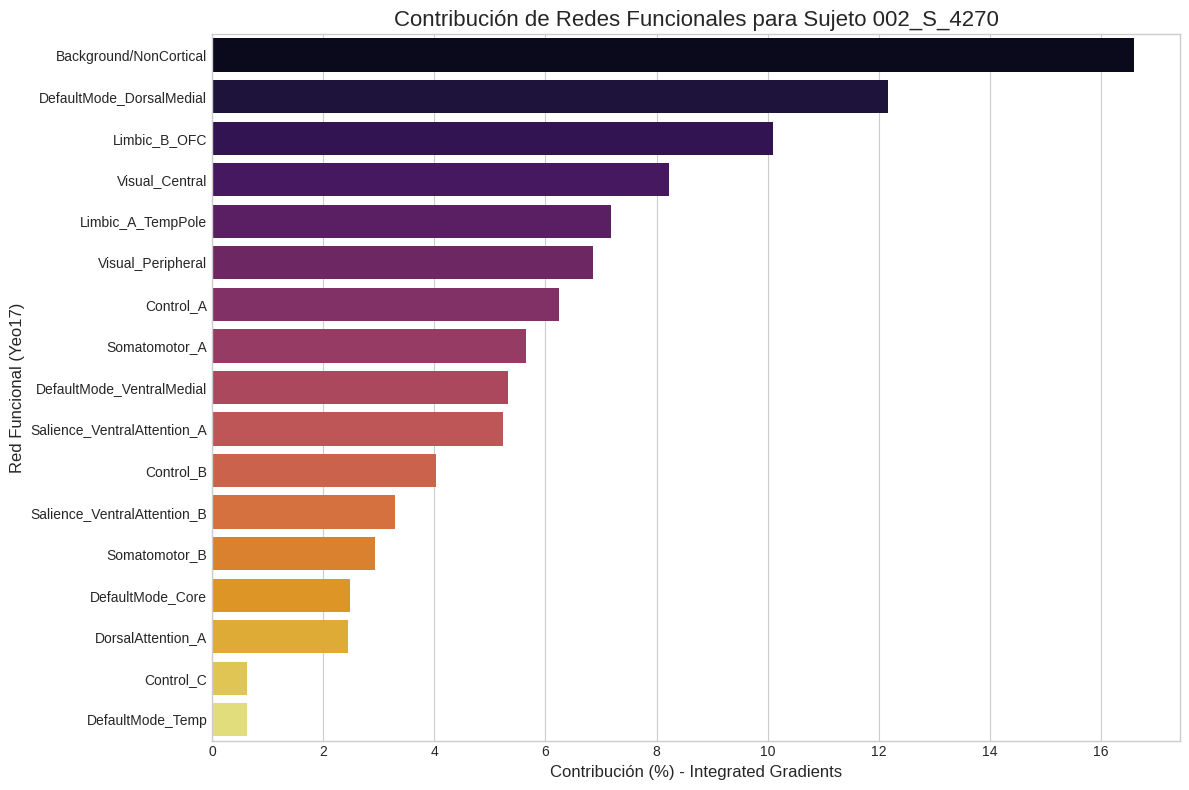

In [4]:


# Visualización
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='contribution_percent', y='Yeo17_Network', data=real_ranked_networks, palette='inferno', ax=ax)
ax.set_title(f'Contribución de Redes Funcionales para Sujeto {subject_to_explain["SubjectID"]}', fontsize=16)
ax.set_xlabel('Contribución (%) - Integrated Gradients', fontsize=12)
ax.set_ylabel('Red Funcional (Yeo17)', fontsize=12)
plt.tight_layout()
plt.savefig("real_network_ranking.png")
print("\nGráfico de ranking de redes (real) guardado como 'real_network_ranking.png'")
plt.show()

In [5]:
# --- PASO ADICIONAL: Calcular Saliencia para TODOS los sujetos del test set ---

all_roi_scores = []
print(f"\nCalculando saliencia para los {len(test_subject_df)} sujetos del conjunto de test...")

for idx, subject_row in test_subject_df.iterrows():
    # Preparamos los tensores de entrada para este sujeto
    subject_tensor_original = global_tensor_data[subject_row['tensor_idx'], :, :, :][CHANNELS_TO_USE, :, :][np.newaxis, ...]
    subject_tensor_norm = apply_normalization_params(subject_tensor_original, norm_params_fold1)
    input_tensor = torch.from_numpy(subject_tensor_norm).float().to(device)
    
    age_val = float(subject_row['Age'])
    sex_val = 1.0 if subject_row['Sex'] == 'F' else 0.0
    metadata_np = np.array([[age_val, sex_val]], dtype=np.float32)
    metadata_tensor = torch.from_numpy(metadata_np).to(device)
    
    # Calculamos atribuciones
    attributions, _ = ig.attribute(inputs=input_tensor, additional_forward_args=(metadata_tensor,), target=0, return_convergence_delta=True)
    saliency_map = attributions.cpu().detach().numpy().squeeze()
    
    # Agregamos y guardamos los scores de ROI
    roi_scores = np.abs(saliency_map).sum(axis=(0, 2))
    all_roi_scores.append(roi_scores)

# Promediamos los scores de todos los sujetos para obtener una importancia GLOBAL
global_roi_saliency = np.mean(all_roi_scores, axis=0)
print(f"\nSaliencia global de ROIs calculada promediando {len(all_roi_scores)} sujetos.")

# Generamos el ranking de redes con estos scores globales
global_ranked_networks = rank_networks_from_roi_saliency(global_roi_saliency, yeo_mapping_df)

# Mostramos y visualizamos el resultado global
print("\n--- RANKING GLOBAL DE REDES FUNCIONALES (Promedio del Fold 1) ---")
global_ranked_networks.round(4)


Calculando saliencia para los 37 sujetos del conjunto de test...

Saliencia global de ROIs calculada promediando 37 sujetos.

--- RANKING GLOBAL DE REDES FUNCIONALES (Promedio del Fold 1) ---


,Yeo17_Network,Yeo17_Label,saliency,contribution_percent
0,Background/NonCortical,0,4.9531,17.358999
1,DefaultMode_DorsalMedial,16,3.1152,10.917700
2,Limbic_B_OFC,10,2.9581,10.367100
3,Limbic_A_TempPole,9,2.4816,8.697100
4,Visual_Central,2,2.1427,7.509600
5,Visual_Peripheral,1,2.0007,7.011800
6,Salience_VentralAttention_A,7,1.6402,5.748400
7,Somatomotor_A,3,1.6195,5.676000
8,DefaultMode_VentralMedial,17,1.4530,5.092400
9,Control_A,12,1.3541,4.745500


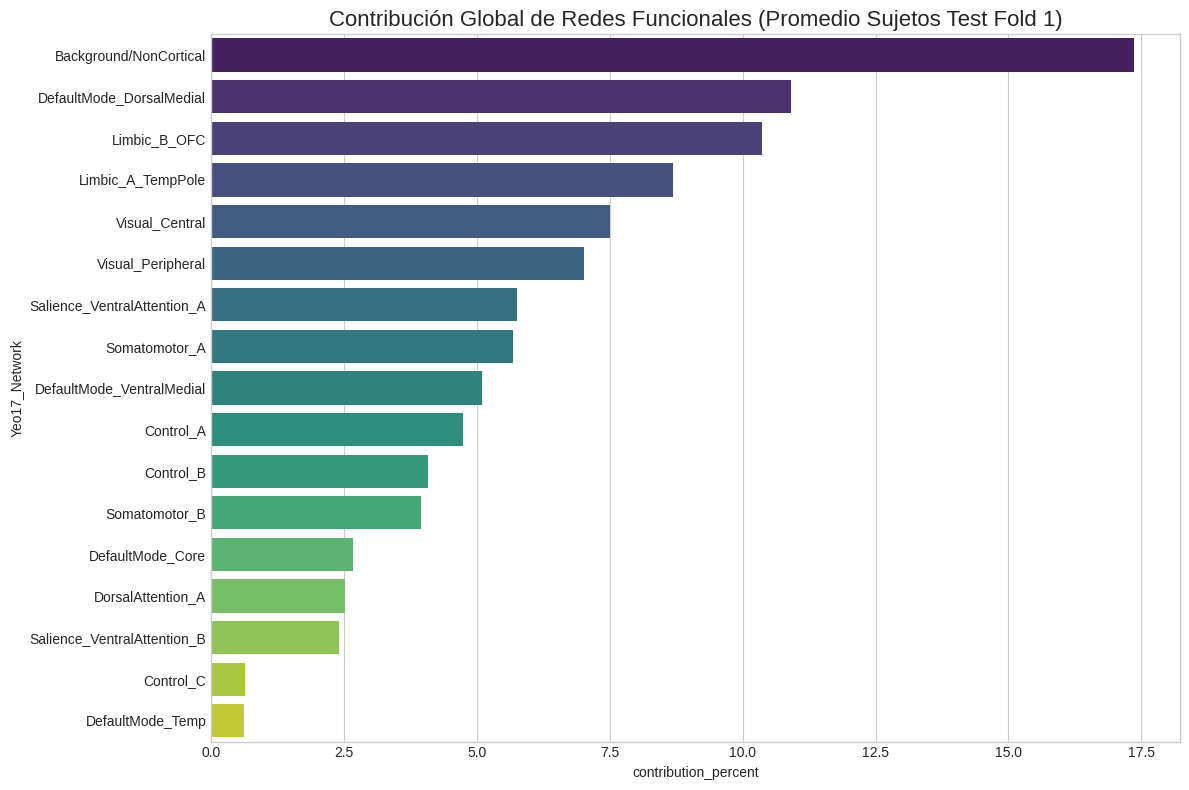

In [6]:

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='contribution_percent', y='Yeo17_Network', data=global_ranked_networks, palette='viridis', ax=ax)
ax.set_title('Contribución Global de Redes Funcionales (Promedio Sujetos Test Fold 1)', fontsize=16)
plt.tight_layout()
plt.savefig("global_real_network_ranking.png")
plt.show()

In [7]:
# --- PASO AVANZADO: Comparar importancia por grupo (CN vs AD) ---

cn_scores = []
ad_scores = []

# Reutilizamos los scores calculados en el bucle anterior
for i, subject_row in enumerate(test_subject_df.iterrows()):
    subject_label = subject_row[1]['ResearchGroup_Mapped']
    if subject_label == 'CN':
        cn_scores.append(all_roi_scores[i])
    elif subject_label == 'AD':
        ad_scores.append(all_roi_scores[i])

# Calculamos la saliencia promedio para cada grupo
mean_cn_saliency = np.mean(cn_scores, axis=0)
mean_ad_saliency = np.mean(ad_scores, axis=0)

# Obtenemos los rankings para cada grupo
cn_ranking = rank_networks_from_roi_saliency(mean_cn_saliency, yeo_mapping_df)
cn_ranking.rename(columns={'contribution_percent': 'CN_contribution_%'}, inplace=True)

ad_ranking = rank_networks_from_roi_saliency(mean_ad_saliency, yeo_mapping_df)
ad_ranking.rename(columns={'contribution_percent': 'AD_contribution_%'}, inplace=True)

# Unimos las tablas para comparar
comparison_df = pd.merge(
    cn_ranking[['Yeo17_Network', 'CN_contribution_%']],
    ad_ranking[['Yeo17_Network', 'AD_contribution_%']],
    on='Yeo17_Network'
)

print("\n--- COMPARACIÓN DE IMPORTANCIA DE REDES: CN vs AD ---")

comparison_df.round(4)



--- COMPARACIÓN DE IMPORTANCIA DE REDES: CN vs AD ---


,Yeo17_Network,CN_contribution_%,AD_contribution_%
0,Background/NonCortical,16.9515,17.772301
1,DefaultMode_DorsalMedial,10.9255,10.909800
2,Limbic_B_OFC,10.3315,10.403200
3,Limbic_A_TempPole,8.5906,8.805100
4,Visual_Central,7.7368,7.279100
5,Visual_Peripheral,7.3371,6.681800
6,Somatomotor_A,5.8806,5.468400
7,Salience_VentralAttention_A,5.5682,5.931200
8,DefaultMode_VentralMedial,5.3240,4.857400
9,Control_A,4.7355,4.755600


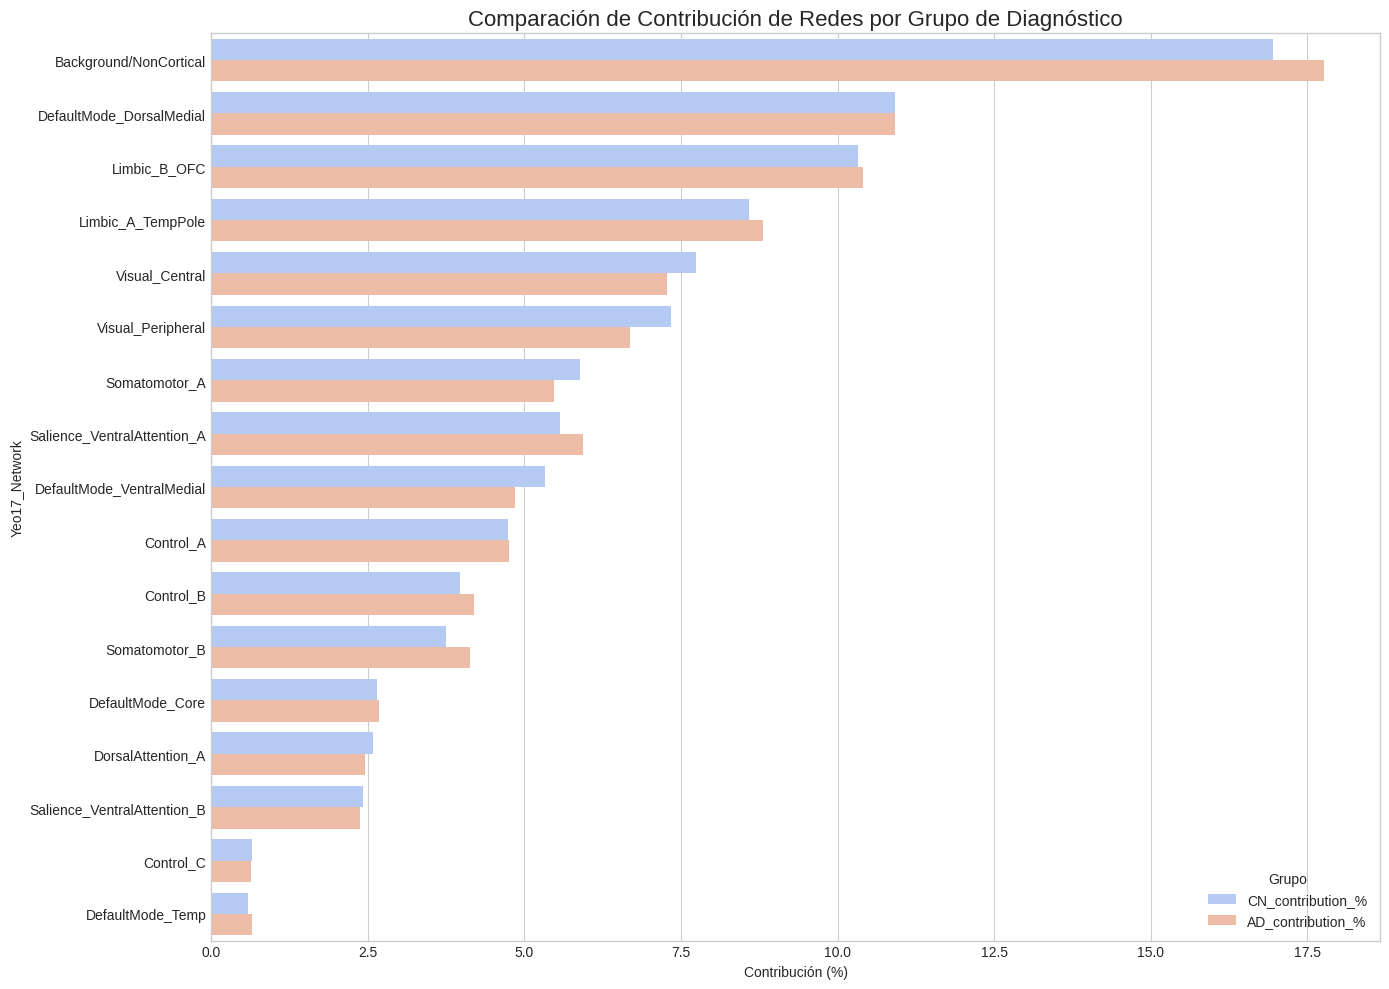

In [8]:

# Visualización comparativa
comparison_df_melted = comparison_df.melt(id_vars='Yeo17_Network', var_name='Grupo', value_name='Contribución (%)')

fig, ax = plt.subplots(figsize=(14, 10))
sns.barplot(x='Contribución (%)', y='Yeo17_Network', hue='Grupo', data=comparison_df_melted, palette='coolwarm', ax=ax)
ax.set_title('Comparación de Contribución de Redes por Grupo de Diagnóstico', fontsize=16)
ax.legend(title='Grupo')
plt.tight_layout()
plt.savefig("cn_vs_ad_network_ranking.png")
plt.show()